In [1]:
import geopandas as gpd

In [ ]:
# read in the demographic variables
to_dems = gpd.read_file('toronto_census_all.shp')



# rename the columns that were auto-shortened
to_dems.rename(columns = {'Percentage': 'Percentage of visible minority',
                           'Median tot': 'Median total income of households in 2020 ($)',
                             'Homeowners':'Homeownership rate (%)'}, inplace=True)

# read in the isochrone variables
to_isos = gpd.read_file('./isochrones_final/isochrones_change_final.shp')

# isolate out geometry and rename columns auto-shortened on last save
isos_df = to_isos[['DGUID', '30_change', '15_change', '30_2015', '30_2025', '15_2015', '15_2025', '15_increas', '30_increas']].rename(
    columns = {'15_increas': '15_increase', '30_increas': '30_increase'})

# merge - MUST be a "right" merge to account for slivers in left dataset!
to_all = to_dems.merge(isos_df.interpolate(), how = 'right', on = 'DGUID')

# this is the ultimate clean total variable shapefile for analysis, save so bivariate can access
to_all.to_file('to_all_variables_for_cluster_analysis.shp')

C:\Users\saman\AppData\Local\Temp\ipykernel_11388\3657474659.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  to_all = to_dems.merge(isos_df.interpolate(), how = 'right', on = 'DGUID')
C:\Users\saman\AppData\Local\Temp\ipykernel_11388\3657474659.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  to_all.to_file('to_all_variables_for_cluster_analysis.shp')
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Percentage of visible minority' to 'Percentage'
  ogr_write(
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized

## LESSON LEARNED ##

The first several attempts at doing any esda Moran's I analysis yielded many errors!
The output from the esda.Moran function was always NaN

To deal with this, I consulted documentation first: https://pysal.org/esda/generated/esda.Moran.html
but I did not see any explanation for how it could yield NaN.

By looking deeper into the PySAL documentation, I found this tutorial: https://pysal.org/notebooks/explore/esda/Spatial_Autocorrelation_for_Areal_Unit_Data.html

This tutorial showed that having any Null or NaN values in the dataset would cause the output to be wrong, and potentially NaN.
So, I used .head and .values to look closer at the data and found NaN values! Only 2 in each of the demographic variables. I also found some slivers in the demographic shapefiles.

To fix this, I followed the tutorial's instruction to fill NaN values which involved using .fillna() and passing it the median value of the dataset.
My teammates and I agreed that rather than inserting the mean, any form of interpolating from neighbours would be preferrable.

So, I added code to the ```create_demographic_maps.ipynb``` so that the data was cleanly interpolated immediately. Cleaning this data on its first instance of use ensures that all maps will be using consistent values in their representations. Here is a snippet of that code:

```
to_ct_cleaned = to_ct[['DGUID', 'geometry']].merge(to_ct[['Percentage of visible minority', 'DGUID']].interpolate(),
                                                    how = 'left', on = 'DGUID')

# merge all the variables, including isochrone variables here (isochrones have no NaN values)
to_all = (to_ct_cleaned.merge(mmhh_to[['Median total income of households in 2020 ($)', 'DGUID']].interpolate(),
                       how = 'left', on = 'DGUID')).merge(hor_to[['Homeownership rate (%)', 'DGUID']].interpolate(),
                                                            how = 'left', on = 'DGUID').merge(isos_df, how = 'left', on = 'DGUID')
                                                            
```

Then all the edsa functions ran smoothly!


In [3]:
import esda
import libpysal as lps

# project
to_all = to_all.to_crs('epsg:3857')

# create weight matrix. Queen contiguity most appropriate given shapes of census tracts
w = lps.weights.Queen.from_dataframe(to_all, use_index=False)

In [4]:
def output_global_stats(gdf, col, weights):
    g_stats = esda.Moran(gdf[col], weights)
    file_name = f"Univariate Global Moran's I Results - {col}"

    I = g_stats.I
    p = g_stats.p_sim
    z = g_stats.z_sim

    output_string = f"{file_name}\nMoran's I: {I}\np-value: {p}\nz-score: {z}\n"

    with open(file_name + ".txt", 'w') as f:
        f.write(file_name)
        f.write(output_string)
    
    return output_string

In [5]:
# Get the global statistics to allow us to discuss significance in the report\

print(output_global_stats(to_all, 'Percentage of visible minority', w))
print(output_global_stats(to_all, 'Median total income of households in 2020 ($)', w))
print(output_global_stats(to_all, 'Homeownership rate (%)', w))
print(output_global_stats(to_all, '30_change', w))
print(output_global_stats(to_all, '30_increase', w))
print(output_global_stats(to_all, '15_change', w))
print(output_global_stats(to_all, '15_increase', w))


Univariate Global Moran's I Results - Percentage of visible minority
Moran's I: 0.5254431786444961
p-value: 0.001
z-score: 23.104758454923406

Univariate Global Moran's I Results - Median total income of households in 2020 ($)
Moran's I: 0.4636222078534422
p-value: 0.001
z-score: 19.6126745220366

Univariate Global Moran's I Results - Homeownership rate (%)
Moran's I: 0.3249445179449491
p-value: 0.001
z-score: 13.899791805817452

Univariate Global Moran's I Results - 30_change
Moran's I: 0.45221445568566077
p-value: 0.001
z-score: 19.15687487060047

Univariate Global Moran's I Results - 30_increase
Moran's I: 0.33075158550458744
p-value: 0.001
z-score: 14.020264565672134

Univariate Global Moran's I Results - 15_change
Moran's I: 0.233413950195723
p-value: 0.001
z-score: 10.333492469961945

Univariate Global Moran's I Results - 15_increase
Moran's I: 0.08195155165671883
p-value: 0.001
z-score: 3.4992093734149092



In [6]:
# get the local moran's I graphs for relevant columns, all are significant so must visualize them all

MMHHmorans_local = esda.Moran_Local(to_all['Median total income of households in 2020 ($)'], w)
HORmorans_local = esda.Moran_Local(to_all['Homeownership rate (%)'], w)
VMmorans_local = esda.Moran_Local(to_all['Percentage of visible minority'], w)
iso_30_change_local = esda.Moran_Local(to_all['30_change'], w)
iso_30_increase_local = esda.Moran_Local(to_all['30_increase'], w)

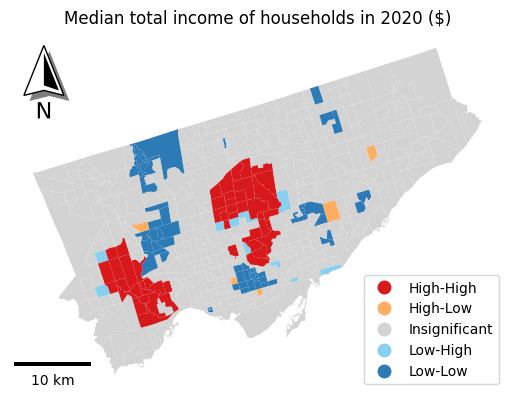

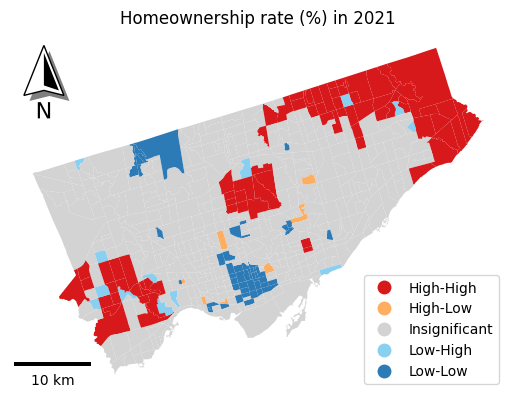

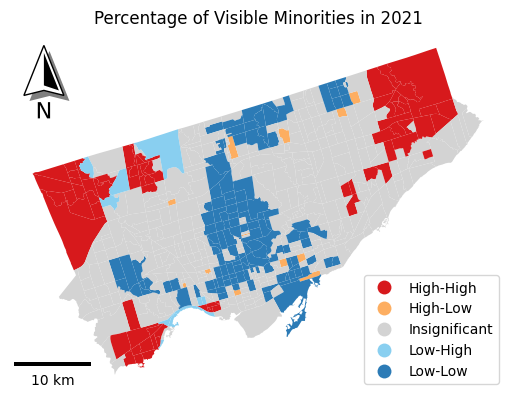

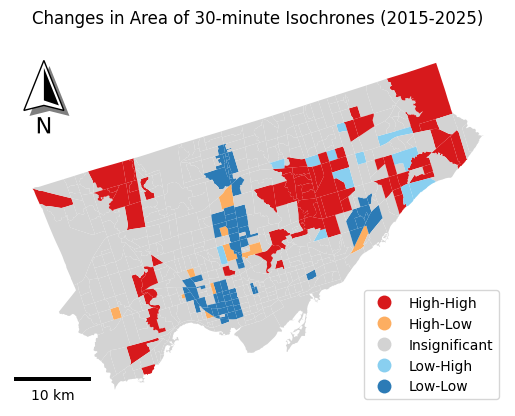

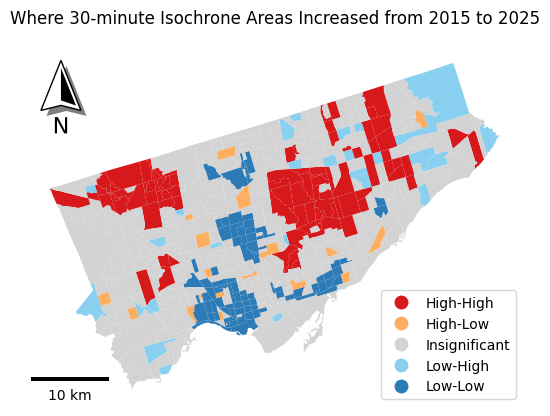

In [7]:
# look at them!

from plotter import plot_local_moran
    
f1, ax = plot_local_moran(MMHHmorans_local, to_all, 'Median total income of households in 2020 ($)')
f2, ax = plot_local_moran(HORmorans_local, to_all, 'Homeownership rate (%) in 2021')
f3, ax = plot_local_moran(VMmorans_local, to_all, 'Percentage of Visible Minorities in 2021')
f4, ax = plot_local_moran(iso_30_change_local, to_all, 'Changes in Area of 30-minute Isochrones (2015-2025)')
f5, ax = plot_local_moran(iso_30_increase_local, to_all, 'Where 30-minute Isochrone Areas Increased from 2015 to 2025')


In [8]:
f1.savefig('Median Income Local Moran Figure.png')
f2.savefig('Homeownership rate (%) in 2021 Local Moran Figure.png')
f3.savefig('Percentage of Visible Minorities in 2021 Local Moran Figure.png')
f4.savefig('Changes in Area of 30-minute Isochrones (2015-2025) Local Moran Figure.png')
f5.savefig('Where 30-minute Isochrone Areas Increased from 2015 to 2025 Local Moran Figure.png')